In [1]:
import getpass
username = getpass.getuser()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/{:}/GitHub/mouse_bandit/data_preprocessing_code'.format(username))
sys.path.append('/Users/{:}/GitHub/mouse_bandit'.format(username))
import support_functions as sf

sys.path.append('/Users/{:}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(username))
import bandit_modeling as bm

import sklearn
from sklearn.model_selection import train_test_split

% matplotlib inline

In [29]:
data = pd.read_csv('/Users/{:}/Dropbox (HMS)/mouse_bandit/markov_full.csv'.format(username), index_col=0)
#data = data[data['Mouse ID']=='Baby']
data = data[data['Condition']=='70-30']
data.head()

,index,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Condition,Block ID,Current Block Length
217080,0,Baby,01222018_Baby,11.0,11.0,3.0,1.0,1.0,0.0,0.0,...,0.533,1.222,0.267,1.0,0.0,1.0,1.0,70-30,1.0,15.0
217081,1,Baby,01222018_Baby,12.0,12.0,4.0,2.0,2.0,1.0,0.0,...,0.267,2.035,0.325,1.0,0.0,1.0,1.0,70-30,1.0,15.0
217082,2,Baby,01222018_Baby,13.0,13.0,5.0,3.0,3.0,1.0,1.0,...,0.325,1.579,0.597,1.0,0.0,1.0,0.0,70-30,1.0,15.0
217083,3,Baby,01222018_Baby,14.0,14.0,5.0,4.0,-1.0,1.0,0.0,...,0.597,2.327,0.452,1.0,0.0,1.0,0.0,70-30,1.0,15.0
217084,4,Baby,01222018_Baby,15.0,0.0,5.0,5.0,-2.0,0.0,0.0,...,0.452,1.524,0.569,1.0,0.0,0.0,0.0,70-30,2.0,20.0


Markov process is one in which the future state of the system does not depend on more (history) than the current state

In [3]:
def hmm_parameters(data,emission_probs,transition_probs,num_trials=10):
    
    n_trials = data.shape[0] #number of trials in training set
    
    '''
    PARAMETERS TO TUNE
    '''
    
    likeli_df = pd.DataFrame(columns=['Likelihood','p','t'])
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)
            
    #loop through parameters
    for p in emission_probs:
        
        q = 1.0-p # prob of reward if choose the incorrect side

        for t in transition_probs:
            '''
            Set up transition matrix and observation matrix
            '''
            #transition matrix
            s = 1 - t
            T = np.array([[s, t],
                         [1.0-s,1.0-t]])
            #observation matrix
            '''
            set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

            eg. when action = R, observation matrix should be:
            O[:,:,0]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
                           P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
                        = [1-p, 1-q
                            p,   q]
            '''
            O = np.zeros((2,2,2))
            # let a 'right' choice be represented by '0'
            O[:,:,0] = np.array([[1.0-p, 1.0-q],
                                 [p,q]])
            O[:,:,1] = np.array([[1.0-q, 1.0-p],
                                 [q,p]])

            #TEST: All conditional probability distributions must sum to one
            #assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!
            '''
            run game
            '''
            likeli = []
            
            for trial in range(n_trials):

                curr_trial = data.iloc[trial]
                actions = curr_trial[port_features].values.astype('int')
                rewards = curr_trial[reward_features].values.astype('int')
                beliefs = np.nan*np.ones((num_trials+1,2))
                beliefs[0] = [0.5,0.5] #initialize both sides with equal probability
                
                #run the algorithm
                for play in range(num_trials):

                    assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"

                    #update neg log likelihood
                    likeli.append(-1*np.log(beliefs[play,actions[play]]))

                    #update beliefs for next play
                    #step 1: multiply by p(r_t | z_t = k, a_t)
                    belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]

                    #step 2: sum over z_t, weighting by transition matrix
                    beliefs[play+1] = T.dot(belief_temp)

                    #step 3: normalize
                    beliefs[play+1] /= beliefs[play+1].sum()

                #update neg log likelihood
                likeli.append(-1*np.log(beliefs[-1,actions[-1]]))
                    
            d = {'Likelihood':np.sum(likeli),'p':p,'t':t}

            likeli_df = likeli_df.append(pd.DataFrame(data=d,index=[0]))
           
        optimal_emmission = likeli_df[likeli_df['Likelihood'] == likeli_df['Likelihood'].min()]['p'].values
        optimal_transition = likeli_df[likeli_df['Likelihood'] == likeli_df['Likelihood'].min()]['t'].values
    
    return [optimal_emmission,optimal_transition,likeli_df]

In [4]:
# function inputs: DATA, EMISSION_PROB, TRANSITION_PROB=0.02, STRATEGY, N_PREV_TRIALS
def hmm_predict(data, emmission_prob, transition_prob=0.02, strategy='greedy', n_prev_trials=10):
    
    '''
    Inputs:
        data = pandas dataframe containing port and reward features
        emission_prob = reward probability observed by the agent
        transition_prob = probability of transitioning between markovian states
        strategy = 'greedy,' 'thompson,' 'eps_greedy'
        n_prev_trials = int 1 to 10, how many previous trials are used to calculate belief state
    '''
    
    # latent state z (0 left, 1 right)
    # action a (0 left, 1 right)
    # reward r (0 no reward, 1 reward)
    # transition_prob (0 to 1)

    # emission probabilities (observed probabilities of reward)
    p = emission_prob # probability of reward for correct side
    q = 1-p # probability of reward for incorrect side
    s = 1-transition_prob # probability of remaining in same state

    # transition matrix T[i,j] = p(i->j)
    T = np.array([[s, transition_prob],
                  [transition_prob, s]])

    # observation array O
    # O[r,z,a] = Pr(reward=r | state=z, action=a)
    O = np.zeros((2,2,2)) # each component has two conditions 0,1
    
    # right choice = 0, no reward = 0, right state = 0
    O[:,:,0] = np.array([[1-p, 1-q],[p,q]]) 
    O[:,:,1] = np.array([[1-q, 1-p],[q,p]])

    # split data into train and test sets (ultimately using same seeds as with LR?)

    n_trials = data.shape[0]

    #include n_prev_trials past choice and reward values (this is most convenient given the current data structure)
    port_features = []
    reward_features = []
    for col in data:
        if '_Port' in col:
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    y_predict = np.zeros(n_trials)
    beliefs = np.zeros(n_trials)

    for trial in range(n_trials):
        curr_trial = data.iloc[trial]
        actions = curr_trial[port_features].values.astype('int')
        rewards = curr_trial[reward_features].values.astype('int')
        beliefs_curr = np.nan*np.ones((n_prev_trials+1,2))
        beliefs_curr[0] = [0.5,0.5] # initial belief is equal for each port

        for i in range(n_prev_trials):

            assert np.allclose(beliefs_curr[i].sum(), 1.0), "Beliefs must sum to one!"

            belief_temp = O[rewards[i],:,actions[i]] * beliefs_curr[i]

            beliefs_curr[i+1] = T.dot(belief_temp) # take dot product of transition matrix and previous belief

            beliefs_curr[i+1] /= beliefs_curr[i+1].sum()
        
        if strategy == 'greedy':
            y_predict[trial] = np.where(beliefs_curr[-1] == beliefs_curr[-1].max())[0][0] 
            
        elif strategy == 'thompson':
            y_predict[trial] = np.random.choice(2,p=[beliefs_curr[-1][0],beliefs_curr[-1][1]])
            #y_predict[trial] = np.random.choice(2,p=[p,q])
        
        elif strategy == 'eps_greedy':
            print('need to work on this one')
        
        beliefs[trial] = beliefs_curr[-1][1]
    
    return y_predict, beliefs

In [30]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=1)

In [9]:
emission_probs = np.arange(0.60,0.95,0.05)
transition_probs = np.arange(0.015,0.045, 0.005)

In [31]:
optimal_emission, optimal_transition, likeli_df = hmm_parameters(data_train, emission_probs, transition_probs)

In [ ]:
optimal_emission = likeli_df_full[likeli_df_full['Likelihood'] == likeli_df_full['Likelihood'].min()]['p'].values
optimal_transition = likeli_df_full[likeli_df_full['Likelihood'] == likeli_df_full['Likelihood'].min()]['t'].values

In [28]:
likeli_df.to_csv(path_or_buf='/Users/celiaberon/Dropbox (HMS)/mouse_bandit/model_outputs/hmm_9010_data_train.csv')

In [ ]:
plt.scatter(likeli_df_full['p'],likeli_df_full['Likelihood'])
plt.xlabel('emission probability')
plt.ylabel('likelihood')
plt.title('70-30')

In [ ]:
plt.scatter(likeli_df_full['t'],likeli_df_full['Likelihood'])
plt.xlabel('transition probability')
plt.ylabel('likelihood')
plt.title('70-30')

In [48]:
likeli_df_full = pd.read_csv('/Users/celiaberon/Dropbox (HMS)/mouse_bandit/model_outputs/hmm_8020_data_train.csv', index_col=None)


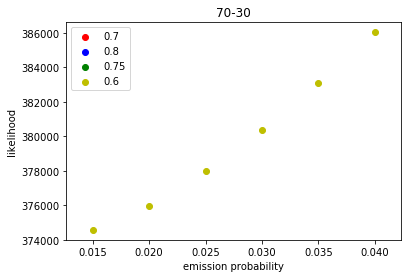

In [50]:
plt.scatter(likeli_df_full[likeli_df_full['p']==0.7]['t'],likeli_df_full[likeli_df_full['p']==0.7]['Likelihood'], color='r', label='0.7')
plt.scatter(likeli_df_full[likeli_df_full['p']==0.8]['t'],likeli_df_full[likeli_df_full['p']==0.8]['Likelihood'], color='b', label='0.8')
plt.scatter(likeli_df_full[likeli_df_full['p']==0.75]['t'],likeli_df_full[likeli_df_full['p']==0.75]['Likelihood'], color='g', label='0.75')
plt.scatter(likeli_df_full[likeli_df_full['p']==0.65]['t'],likeli_df_full[likeli_df_full['p']==0.65]['Likelihood'], color='y', label='0.6')

plt.xlabel('emission probability')
plt.ylabel('likelihood')
plt.title('70-30')
plt.legend()

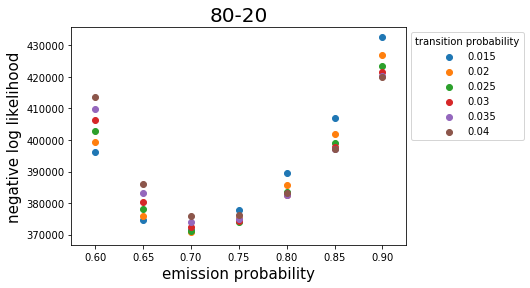

In [63]:
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.015]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.015]['Likelihood'], label='0.015')
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.02]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.02]['Likelihood'], label='0.02')
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.025]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.025]['Likelihood'], label='0.025')
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.03]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.03]['Likelihood'], label='0.03')
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.035]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.035]['Likelihood'], label='0.035')
plt.scatter(likeli_df_full[round(likeli_df_full['t'],3)==0.04]['p'],likeli_df_full[round(likeli_df_full['t'],3)==0.04]['Likelihood'], label='0.04')

plt.xlabel('emission probability', size=15)
plt.ylabel('negative log likelihood', size=15)
plt.title('80-20', size=20)
plt.legend(bbox_to_anchor=(1,1), title='transition probability')

In [ ]:
y_predict, beliefs = hmm_predict(data, optimal_emission[0], optimal_transition[0])

In [ ]:
'''Greedy model'''

decision = data['Decision'].values
prev_decision = data['1_Port'].values

switch = np.abs(decision-prev_decision)
switch_predict = np.abs(y_predict-prev_decision)

accuracy_greedy = np.mean(y_predict==decision)
#accuracy=1-np.abs([y_predict[i]-decision[i] for i in range(len(beliefs))]).sum()/len(beliefs)
print('accuracy = ', accuracy)

precision=1-np.abs([switch_predict[i]-switch[i] for i in np.where(switch_predict==1)]).sum()/np.sum(switch_predict==1)
print('precision =', precision)

recall=1-np.abs([switch_predict[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall)

acc_greedy_switch,acc_greedy_stay,F1=sf.score_both_and_confuse(switch_predict,switch,confusion=False,disp=True)

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

metrics1 = sklearn.metrics.precision_recall_fscore_support(decision, y_predict)

metrics2 = sklearn.metrics.precision_recall_fscore_support(switch, switch_predict)

metrics2

In [ ]:
y_predict_thompson, beliefs = hmm_predict(data, 0.8, strategy='thompson')

In [ ]:
'''With Thompson sampling'''
y_predict=y_predict_thompson

decision = data['Decision'].values
prev_decision = data['1_Port'].values

switch = np.abs(decision-prev_decision)
switch_predict = np.abs(y_predict-prev_decision)

accuracy_thom = np.mean(y_predict==decision)
#accuracy=1-np.abs([y_predict[i]-decision[i] for i in range(len(beliefs))]).sum()/len(beliefs)
print('accuracy = ', accuracy)

precision=1-np.abs([switch_predict[i]-switch[i] for i in np.where(switch_predict==1)]).sum()/np.sum(switch_predict==1)
print('precision =', precision)

recall=1-np.abs([switch_predict[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall)

acc_thom_switch,acc_thom_stay,F1=sf.score_both_and_confuse(switch_predict,switch,confusion=False,disp=True)

In [ ]:
'''win stay lose switch'''

prev_outcome = data['1_Reward'].values
wsls_predict = np.abs(1-prev_outcome)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(wsls_predict,switch,confusion=False,disp=True)

wsls = np.mean(switch[np.where(prev_outcome==0)])
print('fraction switches after unrewarded =', wsls)

accuracy_wsls = np.mean(prev_outcome==switch)

precision_wsls = 1-np.abs([wsls_predict[i]-switch[i] for i in np.where(wsls_predict==1)]).sum()/np.sum(wsls_predict==1)
print('precision =', precision_wsls)

recall_wsls=1-np.abs([wsls_predict[i]-switch[i] for i in np.where(switch==1)]).sum()/np.sum(switch==1)
print('recall =', recall_wsls)

In [ ]:
'''Thompson sampling on beliefs'''
thompson = [np.random.choice(2,p=[beliefs[i],(1-beliefs[i])]) for i in range(len(beliefs))]


In [ ]:
(thompson==y_predict).sum()/len(thompson) # how often do the greedy and thompson hmms agree

In [ ]:
np.mean(beliefs) # should be 0.5 if belief switches between ports.

In [ ]:
lr_acc_switch = 0.128576
lr_acc_stay = 0.86242
lr_acc = 0.87206

height_a = [lr_acc, lr_acc_stay, lr_acc_switch]
height_b = [accuracy_greedy, acc_greedy_stay, acc_greedy_switch]
height_c = [accuracy_thom, acc_thom_stay, acc_thom_switch]

barWidth = 0.2
# The x position of bars
r1 = np.arange(len(height_b))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

conditions = ['full', 'stay', 'switch']
plt.bar(r1, height_a, width=barWidth, label='lr')
plt.bar(r2, height_b, width=barWidth, label='hmm_greedy')
plt.bar(r3, height_c, width=barWidth, label='hmm_thompson')

plt.xticks(range(len(height_b)), conditions)
plt.ylabel('accuracy')
plt.legend()

In [ ]:
X, y = bm.feature_history(data)
switch_predict = pd.Series(y_predict, index=y.index)
reward_combos_hmm, p_switch_hmm = bm.sequences_predict_switch(X,switch_predict)
reward_combos_true, p_switch_true = bm.sequences_predict_switch(X,y)

In [ ]:
p_switch_hmm-p_switch_true

In [ ]:
plt.bar(left=np.arange(len(reward_combos)), height=p_switch_true-p_switch_hmm)